In [1]:
# 순환신경망: 선형회귀를 통한 연속 데이터에 대한 예측 모델도 구현 가능.
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [4]:
def min_max_scaler(data): #정규화 기능 구현
    numerator = data - np.min(data, axis=0) 
    denominator = np.max(data, axis=0) - np.min(data, axis=0)
    return numerator / denominator

In [2]:
#주식데이터도 과거부터 현재까지 일자별 데이터가 시간 순서에 맞춰서 어떤 변화가 있었는지에 따라서 향후 미래를 예측해봐야한다.
#이러한 시계열 데이터가 대표적인 순차데이터인 것이다. (시간 순서에 따라서 담겨진 대표적인 데이터)
data = np.loadtxt('../data/data-02-stock_daily.csv', delimiter=',')
data #배열의 자료형으로 형변환을 해서 넘파이가 데이터를 제공해주고 있는 것을 확인할 수 있다.
#최종적으로는 종가를 예측하는 모델을 만드려고 하는 것임

array([[8.28659973e+02, 8.33450012e+02, 8.28349976e+02, 1.24770000e+06,
        8.31659973e+02],
       [8.23020020e+02, 8.28070007e+02, 8.21655029e+02, 1.59780000e+06,
        8.28070007e+02],
       [8.19929993e+02, 8.24400024e+02, 8.18979980e+02, 1.28170000e+06,
        8.24159973e+02],
       ...,
       [5.66892592e+02, 5.67002574e+02, 5.56932537e+02, 1.08000000e+04,
        5.56972503e+02],
       [5.61202549e+02, 5.66432590e+02, 5.58672539e+02, 4.12000000e+04,
        5.59992565e+02],
       [5.68002570e+02, 5.68002570e+02, 5.52922516e+02, 1.31000000e+04,
        5.58462551e+02]])

In [3]:
data = data[::-1] #마지막 종가를 제외한 데이터를 다시 담아주도록 함 -> 이는 훈련데이터
data
#- 데이터 마지막에 -1로 넣어줌으로 해서 데이터가 저장되어져 있는 순서 자체를 역순으로 정렬함
#데이터 특징을 보게 되면 볼륨의 거래량 단위가 지수값을 나타내는 단위와 그 사용 의미 값이 다르다.
#이렇게 학습을 시켜버리면 수의 의미로 봤을때 거래량이 너무 큰 숫자값이기 때문에 
# 가중치가 높게 책정이 되어 예측률이 높은 모델을 생성해내지 못함 => 정규화를 시켜주도록 한다.

array([[5.68002570e+02, 5.68002570e+02, 5.52922516e+02, 1.31000000e+04,
        5.58462551e+02],
       [5.61202549e+02, 5.66432590e+02, 5.58672539e+02, 4.12000000e+04,
        5.59992565e+02],
       [5.66892592e+02, 5.67002574e+02, 5.56932537e+02, 1.08000000e+04,
        5.56972503e+02],
       ...,
       [8.19929993e+02, 8.24400024e+02, 8.18979980e+02, 1.28170000e+06,
        8.24159973e+02],
       [8.23020020e+02, 8.28070007e+02, 8.21655029e+02, 1.59780000e+06,
        8.28070007e+02],
       [8.28659973e+02, 8.33450012e+02, 8.28349976e+02, 1.24770000e+06,
        8.31659973e+02]])

In [12]:
#훈련용과 테스트용으로 데이터 분리
seq_length = 7
input_feature = 5

train_size = int(len(data) * 0.8) #훈련용으로 80%만 사용하고자 함.
train_input = data[0:train_size] #처음데이터부터 80%의 데이터까지를 훈련데이터의 input으로 사용하고자 함
test_set = data[train_size - seq_length:] #행은 전체를 다 가져오고 열은 지정한 데이터 갯수로 담도록 함

In [7]:
print(train_input.shape, test_set.shape) #739데이터에서 8:2로 데이터를 나눔

(585, 5) (154, 5)


In [8]:
#분리된 데이터를 각각 정규화
train_set = min_max_scaler(train_input)
test_set = min_max_scaler(test_set)

In [9]:
def build_dataset(time_series, seq_length):  #시계열데이터,
    dataX = []
    dataY = []
    
    for i in range(0, len(time_series) - seq_length):
        x = time_series[i:i + seq_length, :] 
        #행은 타임시리즈에 전달받은 길이만큼 모든 행에 있는 컬럼의 데이터를 읽어오도록 함 - x변수에 담겨지도록 함
        y = time_series[i + seq_length, [-1]]
        #정답은 타임시리즈 마지막 컬럼에 있는 항목으로 읽어오도록 요청
        print(x, '->', y)
        dataX.append(x)
        dataY.append(y)
        
    return np.array(dataX), np.array(dataY) #dataX와 dataY를 전달받게끔 정의

In [10]:
trainX, trainY = build_dataset(train_set, seq_length)
testX, testY = build_dataset(test_set, seq_length)

[[2.53065031e-01 2.45070970e-01 2.33983036e-01 4.66075110e-04
  2.32039560e-01]
 [2.29604366e-01 2.39728936e-01 2.54567513e-01 2.98467330e-03
  2.37426028e-01]
 [2.49235510e-01 2.41668371e-01 2.48338489e-01 2.59926504e-04
  2.26793794e-01]
 [2.21013495e-01 2.46602231e-01 2.54710584e-01 0.00000000e+00
  2.62668239e-01]
 [3.63433786e-01 3.70389871e-01 2.67168847e-01 1.24764722e-02
  2.62105010e-01]
 [2.59447633e-01 3.10673724e-01 2.74113889e-01 4.56323384e-01
  2.71751266e-01]
 [2.76008151e-01 2.78314566e-01 1.98470380e-01 5.70171193e-01
  1.78104644e-01]] -> [0.16053716]
[[2.29604366e-01 2.39728936e-01 2.54567513e-01 2.98467330e-03
  2.37426028e-01]
 [2.49235510e-01 2.41668371e-01 2.48338489e-01 2.59926504e-04
  2.26793794e-01]
 [2.21013495e-01 2.46602231e-01 2.54710584e-01 0.00000000e+00
  2.62668239e-01]
 [3.63433786e-01 3.70389871e-01 2.67168847e-01 1.24764722e-02
  2.62105010e-01]
 [2.59447633e-01 3.10673724e-01 2.74113889e-01 4.56323384e-01
  2.71751266e-01]
 [2.76008151e-01 2.7831

In [11]:
print(trainX.shape, trainY.shape)

(578, 7, 5) (578, 1)


In [13]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.LSTM(units=1, input_shape=(seq_length, input_feature)))
#input_shape파라메타 값 지정: 입력데이터의 크기를 7개로 잡아주고 있었음. -> 첫번째 입력값으로 넣기 
#            입력의 크기값은 5개의 핏쳐를 전부 다 입력의 데이터로 사용하도록 구성 -> 두번째 입력값으로 넣기

model.summary() #단순한 모델 생성

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1)                 28        
                                                                 
Total params: 28
Trainable params: 28
Non-trainable params: 0
_________________________________________________________________


In [14]:
model.compile(loss='mse', optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)) #설정셋팅
#최종적으로 선형의 모델을 만들고 싶은 것이므로 mse로 지정

In [15]:
model.fit(trainX, trainY, epochs=100)

Epoch 1/100
19/19 [==============================] - 2s 2ms/step - loss: 0.1700
Epoch 2/100
19/19 [==============================] - 0s 3ms/step - loss: 0.0278
Epoch 3/100
19/19 [==============================] - 0s 2ms/step - loss: 0.0136
Epoch 4/100
19/19 [==============================] - 0s 2ms/step - loss: 0.0065
Epoch 5/100
19/19 [==============================] - 0s 2ms/step - loss: 0.0049
Epoch 6/100
19/19 [==============================] - 0s 2ms/step - loss: 0.0044
Epoch 7/100
19/19 [==============================] - 0s 3ms/step - loss: 0.0040
Epoch 8/100
19/19 [==============================] - 0s 3ms/step - loss: 0.0038
Epoch 9/100
19/19 [==============================] - 0s 3ms/step - loss: 0.0035
Epoch 10/100
19/19 [==============================] - 0s 3ms/step - loss: 0.0033
Epoch 11/100
19/19 [==============================] - 0s 2ms/step - loss: 0.0032
Epoch 12/100
19/19 [==============================] - 0s 3ms/step - loss: 0.0029
Epoch 13/100
19/19 [=================

In [17]:
test_predict = model.predict(testX)
print(testY.shape, test_predict.shape)

5/5 [==============================] - 0s 1ms/step
(147, 1) (147, 1)


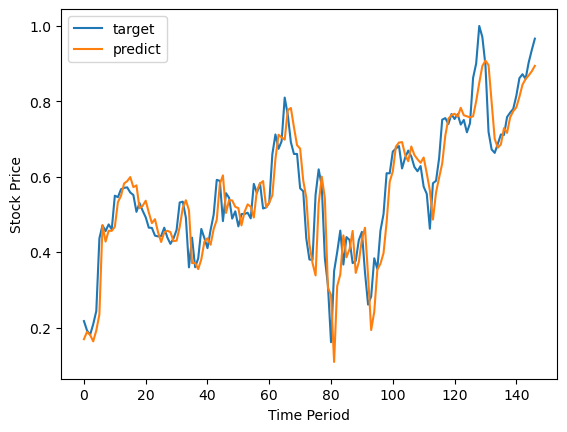

In [18]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

plt.plot(testY) #정답
plt.plot(test_predict) #예측값
plt.xlabel('Time Period')
plt.ylabel('Stock Price')
plt.legend(['target', 'predict'])
plt.show()
#정답데이터와 예측데이터를 시각화하여 출력하도록 함
#모든 시간데이터에 대해서 정확하게 맞춰갈 수는 없지만(선형회귀는 특히) 추세를 추적해가는 것이다. 
#ex) 향후 1개월에서 1분기, 3분기의 추세의 상향과 하향에 대한 예측

#과거 데이터를 가지고 만든 모델의 테스트용으로 따로 한번더 사용해보지 않는 데이터를 넣었을 때
#모델이 예측한 주황색 예측값과 파란색 정답 사이의 값들을 추적해가는 것임. 꼭짓점이 포인트임.